In [2]:
import math

def calculate_tx_size(inputs, outputs, input_type, output_type, m=0, n=0):
    # Fixed fields
    version = 4
    locktime = 4

    # SegWit marker and flag (if SegWit)
    segwit_marker_flag = 2 if 'witness' in input_type else 0

    # VarInt encoding (1-9 bytes based on value)
    def varint_size(n):
        if n < 0xFD: return 1
        elif n <= 0xFFFF: return 3
        elif n <= 0xFFFFFFFF: return 5
        else: return 9

    # Input sizes (base + witness calculation)
    input_sizes = {
        'p2pkh': (148, 0),
        'p2sh': (294, 0),
        'p2wpkh': (41, 108),
        'p2wsh': (59, 0)  # Witness part calculated dynamically
    }

    # Output sizes
    output_sizes = {
        'p2pkh': 34,
        'p2sh': 32,
        'p2wpkh': 31,
        'p2wsh': 43
    }

    # Calculate P2WSH witness size dynamically (for multi-sig)
    def calculate_p2wsh_witness(m, n):
        if m == 0 or n == 0:
            return 0
        signature_size = 73  # DER-encoded signature size (approx.)
        push_opcode = 1
        # Redeem script: OP_M (1 byte) + pubkeys (n * 33 bytes) + OP_N (1 byte) + OP_CHECKMULTISIG (1 byte)
        script_size = 1 + (n * 33) + 2
        return 1 + (m * (signature_size + push_opcode)) + (script_size + 3)

    # Calculate base and witness sizes
    base_size = version + locktime + varint_size(len(inputs)) + varint_size(len(outputs)) + segwit_marker_flag
    input_base, input_witness = input_sizes[input_type]
    output_size = output_sizes[output_type]

    base_size += len(inputs) * input_base + len(outputs) * output_size

    # Adjust witness size for P2WSH (multi-sig case)
    witness_size = len(inputs) * input_witness
    if input_type == 'p2wsh':
        witness_size += len(inputs) * calculate_p2wsh_witness(m, n)

    # Calculate transaction weight and virtual size
    weight = base_size * 4 + witness_size
    vbytes = math.ceil(weight / 4)

    return {
        'base_size': base_size,
        'witness_size': witness_size,
        'weight': weight,
        'vbytes': vbytes
    }

# Example 1: 2 P2WPKH inputs, 2 P2PKH outputs
tx_info = calculate_tx_size([1, 1], [1, 1], 'p2wpkh', 'p2pkh')
print("P2WPKH Transaction:", tx_info)

# Example 2: 1 P2WSH input (2-of-3 multi-sig), 2 P2WPKH outputs
tx_info = calculate_tx_size([1], [1, 1], 'p2wsh', 'p2wpkh', m=2, n=3)
print("P2WSH (2-of-3 Multi-sig) Transaction:", tx_info)


P2WPKH Transaction: {'base_size': 160, 'witness_size': 216, 'weight': 856, 'vbytes': 214}
P2WSH (2-of-3 Multi-sig) Transaction: {'base_size': 131, 'witness_size': 254, 'weight': 778, 'vbytes': 195}


In [3]:
import math

def calculate_tx_size(inputs, outputs, input_types, output_types, multisig_params=None):
    # Fixed fields
    version = 4
    locktime = 4

    # VarInt encoding (1-9 bytes based on value)
    def varint_size(n):
        if n < 0xFD: return 1
        elif n <= 0xFFFF: return 3
        elif n <= 0xFFFFFFFF: return 5
        else: return 9

    # Input sizes (base + witness calculation)
    input_sizes = {
        'p2pkh': (148, 0),
        'p2sh': (294, 0),
        'p2wpkh': (41, 108),
        'p2wsh': (59, 0)  # Witness part calculated dynamically
    }

    # Output sizes
    output_sizes = {
        'p2pkh': 34,
        'p2sh': 32,
        'p2wpkh': 31,
        'p2wsh': 43
    }

    # Calculate P2WSH witness size dynamically (for multi-sig)
    def calculate_p2wsh_witness(m, n):
        if m == 0 or n == 0:
            return 0
        signature_size = 73  # DER-encoded signature size (approx.)
        push_opcode = 1
        # Redeem script: OP_M (1 byte) + pubkeys (n * 33 bytes) + OP_N (1 byte) + OP_CHECKMULTISIG (1 byte)
        script_size = 1 + (n * 33) + 2
        return 1 + (m * (signature_size + push_opcode)) + (script_size + 3)

    # Base transaction size
    base_size = version + locktime + varint_size(sum(inputs)) + varint_size(sum(outputs))

    # Add SegWit marker and flag if any input is SegWit
    is_segwit = any('witness' in inp for inp in input_types)
    if is_segwit:
        base_size += 2

    # Calculate input and witness sizes
    witness_size = 0

    for inp_count, inp_type in zip(inputs, input_types):
        input_base, input_witness = input_sizes[inp_type]
        base_size += inp_count * input_base

        if inp_type == 'p2wsh' and multisig_params:
            m, n = multisig_params.get(inp_type, (0, 0))
            witness_size += inp_count * calculate_p2wsh_witness(m, n)

        witness_size += inp_count * input_witness

    # Calculate output size
    for out_count, out_type in zip(outputs, output_types):
        base_size += out_count * output_sizes[out_type]

    # Weight and virtual size calculation
    weight = base_size * 4 + witness_size
    vbytes = math.ceil(weight / 4)

    return {
        'base_size': base_size,
        'witness_size': witness_size,
        'weight': weight,
        'vbytes': vbytes
    }

# Example 1: 2 P2WPKH inputs, 2 P2PKH outputs
tx_info = calculate_tx_size([1, 1], [1, 1], ['p2wpkh', 'p2wpkh'], ['p2pkh', 'p2pkh'])
print("P2WPKH Transaction:", tx_info)

# Example 2: 1 P2WSH input (2-of-3 multi-sig), 2 P2WPKH outputs
tx_info = calculate_tx_size([1], [1, 1], ['p2wsh'], ['p2wpkh', 'p2wpkh'], multisig_params={'p2wsh': (2, 3)})
print("P2WSH (2-of-3 Multi-sig) Transaction:", tx_info)

# Example 1: 5 participants CoinJoin (3 P2WPKH, 2 P2PKH inputs), 5 outputs
tx_info = calculate_tx_size(
    inputs=[3, 2],
    outputs=[5],
    input_types=['p2wpkh', 'p2pkh'],
    output_types=['p2wpkh']
)
print("CoinJoin Transaction (5 participants):", tx_info)

# Example 2: 3 P2WSH (2-of-3 multi-sig) inputs, 3 uniform P2WPKH outputs
tx_info = calculate_tx_size(
    inputs=[3],
    outputs=[3],
    input_types=['p2wsh'],
    output_types=['p2wpkh'],
    multisig_params={'p2wsh': (2, 3)}
)
print("Multi-sig CoinJoin Transaction:", tx_info)


P2WPKH Transaction: {'base_size': 160, 'witness_size': 216, 'weight': 856, 'vbytes': 214}
P2WSH (2-of-3 Multi-sig) Transaction: {'base_size': 131, 'witness_size': 254, 'weight': 778, 'vbytes': 195}
CoinJoin Transaction (5 participants): {'base_size': 584, 'witness_size': 324, 'weight': 2660, 'vbytes': 665}
Multi-sig CoinJoin Transaction: {'base_size': 280, 'witness_size': 762, 'weight': 1882, 'vbytes': 471}


In [4]:
# Lightning channel opening: 1 P2WPKH input, 1 P2WSH (2-of-2 multi-sig) output
tx_info = calculate_tx_size(
    inputs=[4],
    outputs=[2],
    input_types=['p2wpkh'],
    output_types=['p2wsh'],
    multisig_params={'p2wsh': (2, 2)}
)
print("Lightning Channel Opening Transaction:", tx_info)


Lightning Channel Opening Transaction: {'base_size': 260, 'witness_size': 432, 'weight': 1472, 'vbytes': 368}


In [5]:
import math

def calculate_tx_size(inputs, outputs, input_types, output_types, multisig_params=None):
    # Fixed fields
    version = 4
    locktime = 4

    # VarInt encoding (1-9 bytes based on value)
    def varint_size(n):
        if n < 0xFD: return 1
        elif n <= 0xFFFF: return 3
        elif n <= 0xFFFFFFFF: return 5
        else: return 9

    # Input sizes (base + witness calculation)
    input_sizes = {
        'p2pkh': (148, 0),
        'p2sh': (294, 0),
        'p2wpkh': (41, 108),
        'p2wsh': (59, 0),  # Witness part calculated dynamically
        'p2tr': (57, 65)  # Taproot (Key-path spend)
    }

    # Output sizes
    output_sizes = {
        'p2pkh': 34,
        'p2sh': 32,
        'p2wpkh': 31,
        'p2wsh': 43,
        'p2tr': 43  # Taproot output
    }

    # Calculate P2WSH witness size dynamically (for multi-sig)
    def calculate_p2wsh_witness(m, n):
        if m == 0 or n == 0:
            return 0
        signature_size = 73  # DER-encoded signature size (approx.)
        push_opcode = 1
        # Redeem script: OP_M (1 byte) + pubkeys (n * 33 bytes) + OP_N (1 byte) + OP_CHECKMULTISIG (1 byte)
        script_size = 1 + (n * 33) + 2
        return 1 + (m * (signature_size + push_opcode)) + (script_size + 3)

    # Base transaction size
    base_size = version + locktime + varint_size(sum(inputs)) + varint_size(sum(outputs))

    # Add SegWit marker and flag if any input is SegWit
    is_segwit = any(inp in ['p2wpkh', 'p2wsh', 'p2tr'] for inp in input_types)
    if is_segwit:
        base_size += 2

    # Calculate input and witness sizes
    witness_size = 0

    for inp_count, inp_type in zip(inputs, input_types):
        input_base, input_witness = input_sizes[inp_type]
        base_size += inp_count * input_base

        if inp_type == 'p2wsh' and multisig_params:
            m, n = multisig_params.get(inp_type, (0, 0))
            witness_size += inp_count * calculate_p2wsh_witness(m, n)

        witness_size += inp_count * input_witness

    # Calculate output size
    for out_count, out_type in zip(outputs, output_types):
        base_size += out_count * output_sizes[out_type]

    # Weight and virtual size calculation
    weight = base_size * 4 + witness_size
    vbytes = math.ceil(weight / 4)

    return {
        'base_size': base_size,
        'witness_size': witness_size,
        'weight': weight,
        'vbytes': vbytes
    }

# Example 1: 5 participants CoinJoin (3 P2WPKH, 2 P2PKH inputs), 5 outputs
tx_info = calculate_tx_size(
    inputs=[3, 2],
    outputs=[5],
    input_types=['p2wpkh', 'p2pkh'],
    output_types=['p2wpkh']
)
print("CoinJoin Transaction (5 participants):", tx_info)

# Example 2: 3 P2WSH (2-of-3 multi-sig) inputs, 3 uniform P2WPKH outputs
tx_info = calculate_tx_size(
    inputs=[3],
    outputs=[3],
    input_types=['p2wsh'],
    output_types=['p2wpkh'],
    multisig_params={'p2wsh': (2, 3)}
)
print("Multi-sig CoinJoin Transaction:", tx_info)

# Example 3: Taproot transaction (2 P2TR inputs, 2 P2TR outputs)
tx_info = calculate_tx_size(
    inputs=[2],
    outputs=[2],
    input_types=['p2tr'],
    output_types=['p2tr']
)
print("Taproot Transaction:", tx_info)

# Lightning channel opening: 1 P2WPKH input, 1 P2WSH (2-of-2 multi-sig) output
tx_info = calculate_tx_size(
    inputs=[4],
    outputs=[2],
    input_types=['p2wpkh'],
    output_types=['p2wsh'],
    multisig_params={'p2wsh': (2, 2)}
)
print("Lightning Channel Opening Transaction:", tx_info)


CoinJoin Transaction (5 participants): {'base_size': 586, 'witness_size': 324, 'weight': 2668, 'vbytes': 667}
Multi-sig CoinJoin Transaction: {'base_size': 282, 'witness_size': 762, 'weight': 1890, 'vbytes': 473}
Taproot Transaction: {'base_size': 212, 'witness_size': 130, 'weight': 978, 'vbytes': 245}
Lightning Channel Opening Transaction: {'base_size': 262, 'witness_size': 432, 'weight': 1480, 'vbytes': 370}


In [10]:
# Example 1: 2 P2WPKH inputs, 2 P2PKH outputs
tx_info = calculate_tx_size([5], [1, 1], ['p2wpkh'], ['p2pkh', 'p2pkh'])
print("P2WPKH Transaction:", tx_info)

P2WPKH Transaction: {'base_size': 285, 'witness_size': 540, 'weight': 1680, 'vbytes': 420}


In [165]:
# Example 10 utxo consolidation transaction
tx_info = calculate_tx_size([10], [1], ['p2wpkh'], ['p2wpkh'])
print("UTXO Consolidation Transaction:", tx_info)

UTXO Consolidation Transaction: {'base_size': 453, 'witness_size': 1080, 'weight': 2892, 'vbytes': 723}


In [136]:
### create a function that computes the uses the transaction size in vbytes and calculate the total fee in sats for fee rate in sats/vbyte from 1 to 500 sats/vbyte
def calculate_fee(vbytes, fee_rate):
    return vbytes * fee_rate

# Example 1: 2 P2WPKH inputs, 2 P2PKH outputs
tx_info = calculate_tx_size([1], [1, 1], ['p2wpkh'], ['p2pkh', 'p2pkh'])
print("P2WPKH Transaction:", tx_info)

# Lightning channel opening: 1 P2WPKH input, 1 P2WSH (2-of-2 multi-sig) output
#tx_info = calculate_tx_size(
#    inputs=[4],
#    outputs=[2],
#    input_types=['p2wpkh'],
#    output_types=['p2wsh'],
#    multisig_params={'p2wsh': (2, 2)}
#)
#print("Lightning Channel Opening Transaction:", tx_info)

fees = []
for fee_rate in range(1, 501):
    fee = calculate_fee(tx_info['vbytes'], fee_rate)
    fees.append(fee)


P2WPKH Transaction: {'base_size': 121, 'witness_size': 108, 'weight': 592, 'vbytes': 148}


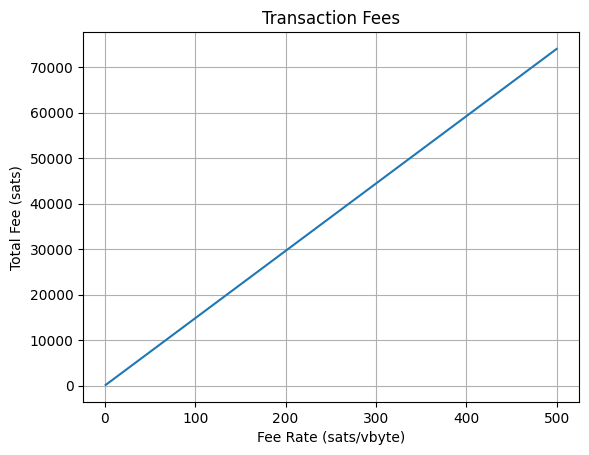

In [137]:
### plot fees
import matplotlib.pyplot as plt
plt.plot(range(1, 501), fees)
plt.xlabel('Fee Rate (sats/vbyte)')
plt.ylabel('Total Fee (sats)')
plt.title('Transaction Fees')
plt.grid(True)
plt.show()



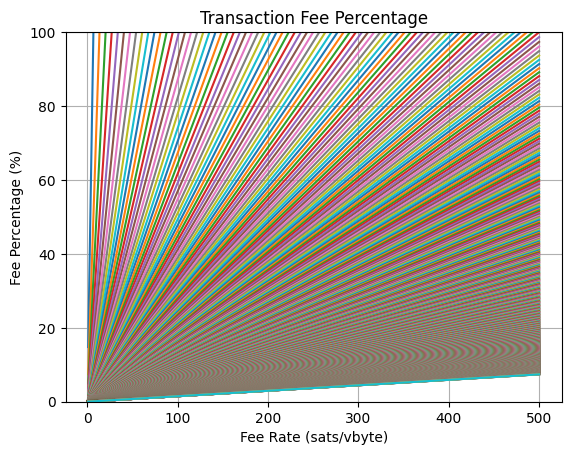

In [138]:
### create sats_utxo as a list of utxo sizes from 1,000 sats to 1,000,000 sats in 1,000 sats increments
sats_utxo = list(range(1000, 1000001, 1000))

### calculate the percentage of fees for each fee rate on sats_utxo
fee_percentages = {}
for utxo in sats_utxo:
    fee_percentages[utxo] = []
    for fee_rate in range(1, 501):
        fee = calculate_fee(tx_info['vbytes'], fee_rate)
        fee_percentage = (fee / utxo) * 100
        fee_percentages[utxo].append(fee_percentage)

### plot fee percentages
for utxo, percentages in fee_percentages.items():
    plt.plot(range(1, 501), percentages, label=f'{utxo} sats')
plt.xlabel('Fee Rate (sats/vbyte)')
plt.ylabel('Fee Percentage (%)')
plt.title('Transaction Fee Percentage')
### max out the y axis to 100
plt.ylim(0, 100)
plt.grid(True)
plt.show()



In [170]:
### Calculate the curve that represents the poit at which the fee percentage is 100% for each fee rate
fee_rates = {}
for utxo, percentages in fee_percentages.items():
    for fee_rate, percentage in enumerate(percentages):
        if percentage >= 50:               
            fee_rates[utxo] = fee_rate
            break    


In [171]:
print(len(sats_utxo), len(fee_rates))

1000 148


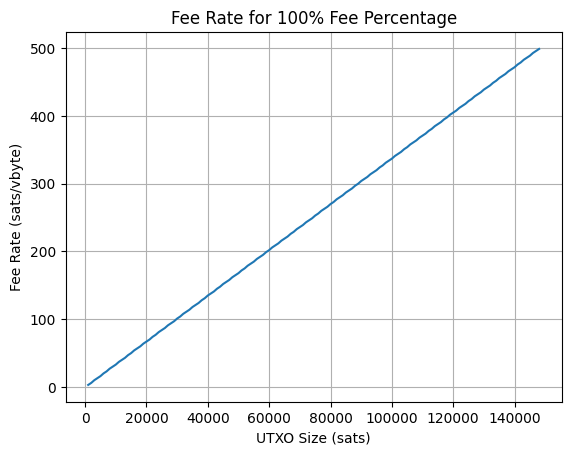

In [172]:
existUTXOs = fee_rates.keys()
existRates = fee_rates.values()

### Plot fee_rates
plt.plot(existUTXOs, existRates)
plt.xlabel('UTXO Size (sats)')
plt.ylabel('Fee Rate (sats/vbyte)')
plt.title('Fee Rate for 100% Fee Percentage')
plt.grid(True)
plt.show()


In [173]:
### UTXO Size calculator based on valuation of bitcoin and savings
averageMonthlySavings = 15.16
### Create list of bitcoinValues from 90000 to 1000000 in 10000 increments
bitcoinValues = list(range(90000, 1000001, 10000))
### Create a dictionary of UTXO sizes based on the bitcoinValues
utxoSizes = {}
for value in bitcoinValues:
    utxoSizes[value] = (averageMonthlySavings / value)*100000000

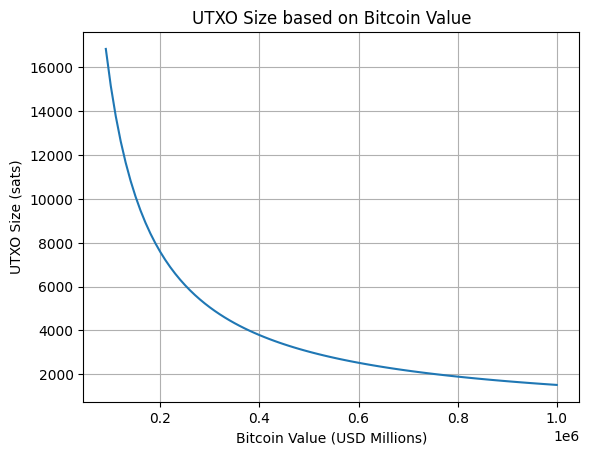

In [174]:
### Plot the utxoSizes
plt.plot(bitcoinValues, list(utxoSizes.values()))
plt.xlabel('Bitcoin Value (USD Millions)')
plt.ylabel('UTXO Size (sats)')
plt.title('UTXO Size based on Bitcoin Value')
plt.grid(True)
plt.show()

In [175]:
normalizedRates = []
for value in utxoSizes.values():
    ### round value up to the nearest 1000
    value = math.ceil(value / 1000) * 1000
    if value in fee_rates:
        normalizedRates.append(fee_rates[value])
    else:
        normalizedRates.append(500)

print(len(normalizedRates))

92


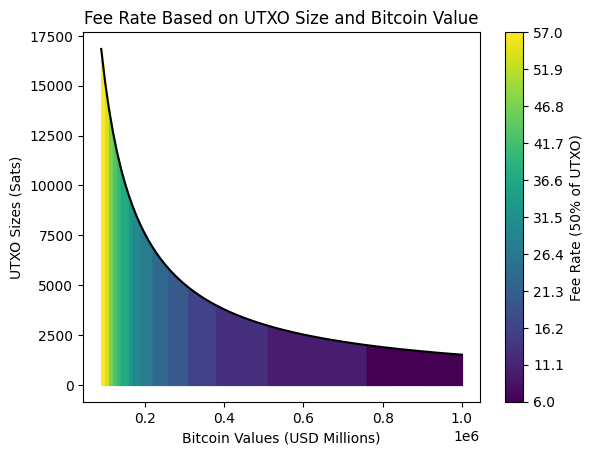

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assuming bitcoinValues, utxoSizes, and normalizedRates are already defined

x = bitcoinValues               # X values (e.g., Time or Index)
y = list(utxoSizes.values())    # Y values (Curve)

# Ensure normalizedRates is a NumPy array
normalizedRates_array = np.array(normalizedRates)

# Map normalizedRates to discrete color bins
bins = np.linspace(np.min(normalizedRates_array), np.max(normalizedRates_array), 100)  
colors = np.digitize(normalizedRates_array, bins)

# Normalize using the actual range of normalizedRates_array
norm = mcolors.Normalize(vmin=np.min(normalizedRates_array), vmax=np.max(normalizedRates_array))
cmap = cm.viridis  # Choose your favorite colormap

# Plot the main curve
plt.plot(x, y, color='black')

# Fill under the curve with heatmap colors based on normalizedRates_array
for i in range(len(x) - 1):
    plt.fill_between(x[i:i+2], y[i:i+2], color=cmap(norm(normalizedRates_array[i])))

# Create a colorbar reflecting the actual normalizedRates values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(normalizedRates_array)  # Use the actual values for the colorbar
cbar = plt.colorbar(sm, label='Fee Rate (50% of UTXO)')

# Optional: Customize tick locations and labels on the colorbar
cbar.set_ticks(np.linspace(np.min(normalizedRates_array), np.max(normalizedRates_array), 11))

plt.xlabel('Bitcoin Values (USD Millions)')
plt.ylabel('UTXO Sizes (Sats)')
plt.title('Fee Rate Based on UTXO Size and Bitcoin Value')
plt.savefig('./images/utxo_bitcoinValue_spendable_size.png')
plt.show()


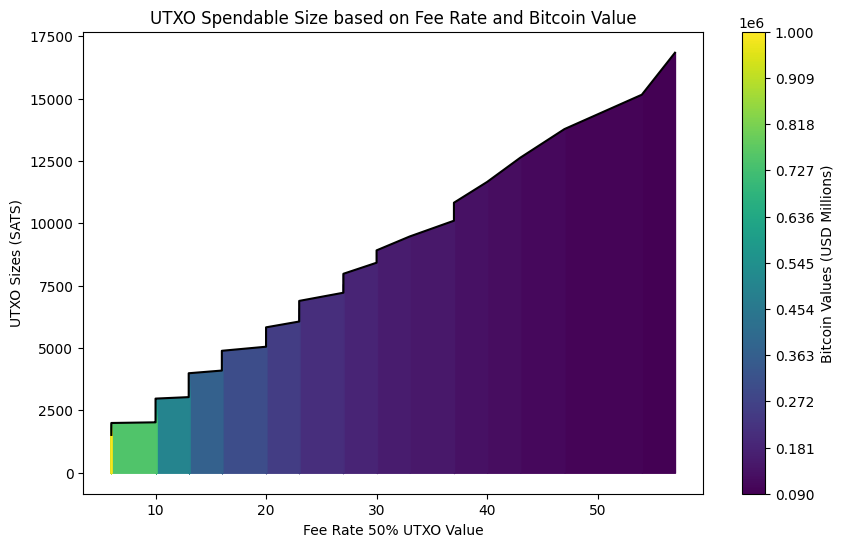

In [168]:
# Assuming bitcoinValues, utxoSizes, and normalizedRates are already defined

x = np.array(normalizedRates)   # X-axis now represents Fee Rates
y = np.array(list(utxoSizes.values()))    # Y values (Curve)

# Ensure bitcoinValues is a NumPy array for the colorbar
bitcoinValues_array = np.array(bitcoinValues)

# Normalize bitcoinValues for the color mapping (color reflects bitcoinValues)
norm = mcolors.Normalize(vmin=bitcoinValues_array.min(), vmax=bitcoinValues_array.max())
cmap = cm.viridis  # Choose your preferred colormap

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the main curve
plt.plot(x, y, color='black')

# Fill under the curve with heatmap colors based on bitcoinValues
for i in range(len(x) - 1):
    plt.fill_between(x[i:i+2], y[i:i+2], color=cmap(norm(bitcoinValues_array[i])))

# Create a colorbar reflecting bitcoinValues
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(bitcoinValues_array)  # Use bitcoinValues for the colorbar
cbar = plt.colorbar(sm, label='Bitcoin Values (USD Millions)')

# Customize tick locations and labels
cbar.set_ticks(np.linspace(bitcoinValues_array.min(), bitcoinValues_array.max(), 11))

plt.xlabel('Fee Rate 50% UTXO Value')  # Now represents Fee Rate
plt.ylabel('UTXO Sizes (SATS)')
plt.title('UTXO Spendable Size based on Fee Rate and Bitcoin Value')

### Save image to ./images/utxo_spendable_size.png
plt.savefig('./images/utxo_spendable_size.png')
plt.show()


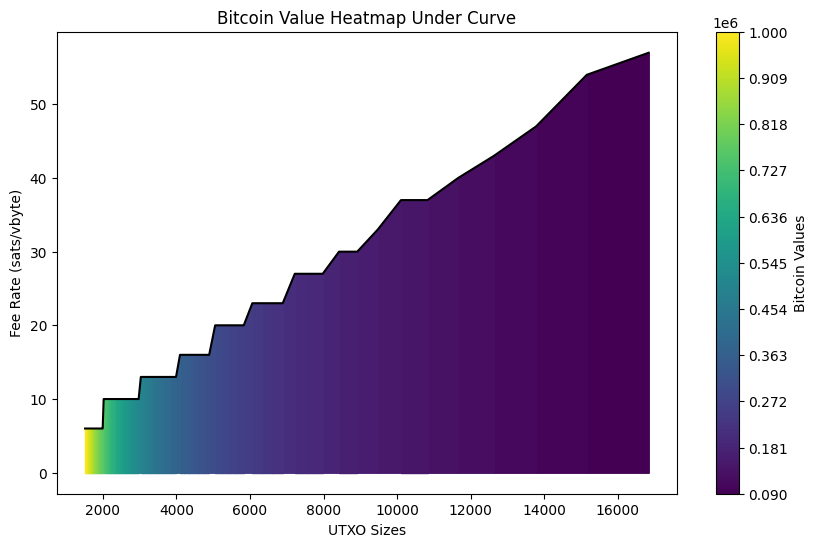

In [164]:
# Assuming bitcoinValues, utxoSizes, and normalizedRates are already defined

x = np.array(list(utxoSizes.values()))  # X-axis (UTXO Sizes)
y = np.array(normalizedRates)           # Y-axis (Fee Rates)
bitcoinValues_array = np.array(bitcoinValues)  # Colors (Bitcoin Values)

# Normalize bitcoinValues for the colormap
norm = mcolors.Normalize(vmin=bitcoinValues_array.min(), vmax=bitcoinValues_array.max())
cmap = cm.viridis  # Choose your preferred colormap

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the main curve
plt.plot(x, y, color='black')

# Fill under the curve with heatmap colors based on bitcoinValues
for i in range(len(x) - 1):
    plt.fill_between(x[i:i+2], y[i:i+2], color=cmap(norm(bitcoinValues_array[i])))

# Create a colorbar reflecting Bitcoin Values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(bitcoinValues_array)  # Map the colorbar to Bitcoin Values
cbar = plt.colorbar(sm, label='Bitcoin Values')

# Customize tick locations and labels on the colorbar
cbar.set_ticks(np.linspace(bitcoinValues_array.min(), bitcoinValues_array.max(), 11))

plt.xlabel('UTXO Sizes')
plt.ylabel('Fee Rate (sats/vbyte)')
plt.title('Bitcoin Value Heatmap Under Curve')

plt.show()
